<a href="https://colab.research.google.com/github/darisoy/EE517_Sp21/blob/master/hw2/EE517_HW2_BERT_SST2_base_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 2.1MB 8.3MB/s 
     |████████████████████████████████| 901kB 33.7MB/s 
     |████████████████████████████████| 3.3MB 52.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import math
import torch
from tqdm.notebook import tqdm
import pickle
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
# check the available device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


### Load and check the data

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/SST-2/train.tsv', delimiter='\t')
df_dev = pd.read_csv('/content/drive/MyDrive/SST-2/dev.tsv', delimiter='\t')
df_test = pd.read_csv('/content/drive/MyDrive/SST-2/test.tsv', delimiter='\t')

In [6]:
print("Training data: ", len(df_train))
print("Dev data: ", len(df_dev))
print("Test data: ", len(df_test))

Training data:  67349
Dev data:  872
Test data:  1821


### Load the model

In [8]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

### Preprocessing before sending to the model

In [9]:
def get_max_len(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

In [10]:
# This turns every sentence into the list of ids
tokenized_train = df_train['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_dev = df_dev['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [11]:
# Padding
max_len = max(get_max_len(tokenized_train), get_max_len(tokenized_dev))
padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
padded_dev = np.array([i + [0]*(max_len-len(i)) for i in tokenized_dev.values])

print("Padded shape (train): ", np.array(padded_train).shape)
print("Padded shape (dev): ", np.array(padded_dev).shape)

Padded shape (train):  (67349, 66)
Padded shape (dev):  (872, 66)


In [12]:
# Tell BERT to ignore padding
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_dev = np.where(padded_dev != 0, 1, 0)

In [13]:
label_train_orig = df_train['label'].to_numpy()
label_dev_orig = df_dev['label'].to_numpy()

In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(padded_train), torch.from_numpy(attention_mask_train), torch.from_numpy(label_train_orig))
valid_data = TensorDataset(torch.from_numpy(padded_dev), torch.from_numpy(attention_mask_dev), torch.from_numpy(label_dev_orig))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_mask_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample input mask size: ', sample_mask_x.size()) # batch_size, seq_length
print('Sample input mask: \n', sample_mask_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 66])
Sample input: 
 tensor([[  101,  3940,  2008,  ...,     0,     0,     0],
        [  101,  1997,  5107,  ...,     0,     0,     0],
        [  101,  2003, 14469,  ...,     0,     0,     0],
        ...,
        [  101,  2003, 27547,  ...,     0,     0,     0],
        [  101,  2070,  1997,  ...,     0,     0,     0],
        [  101,  1037,  5470,  ...,     0,     0,     0]])

Sample input mask size:  torch.Size([64, 66])
Sample input mask: 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])


### Using BERT to encode

In [16]:
def get_embeddings(target_loader):

    model.eval()
    model.to(device)

    all_embed = []
    all_label = []

    for sample, sample_mask, label in target_loader:
        with torch.no_grad():
            sample, sample_mask = sample.to(device), sample_mask.to(device)
            last_hidden_states = model(sample, attention_mask=sample_mask)
            # get all sentences, all hidden unit outputs, at [CLS] (if output hidden state)
            all_embed.append(last_hidden_states[0][:,0,:])
            all_label.append(label)

    return torch.cat(all_embed,dim =0), torch.cat(all_label)

In [17]:
train_embed, train_label = get_embeddings(train_loader)
dev_embed, dev_label = get_embeddings(valid_loader)

In [18]:
train_embed = train_embed.cpu().numpy()
dev_embed = dev_embed.cpu().numpy()
print("train features and labels: ", train_embed.shape, train_label.shape)
print("dev features and labels: ", dev_embed.shape, dev_label.shape)

train features and labels:  (67349, 768) torch.Size([67349])
dev features and labels:  (872, 768) torch.Size([872])


In [19]:
bert_embeddings = [train_embed, train_label, dev_embed, dev_label]

In [20]:

# Instead of taking a long time get the embeddings again, we save them
with open('/content/drive/MyDrive/SST-2/ee517_hw2_bert_embeddings_finetune.data', 'wb') as data_save:
    # store the data as binary data stream
    pickle.dump(bert_embeddings, data_save)

### Logistic Regression Classifier on top of BERT

In [21]:
# Now we can just load the embeddings
with open('/content/drive/MyDrive/SST-2/ee517_hw2_bert_embeddings_finetune.data', 'rb') as filehandle:
    # read the data as binary data stream
    train_embed, train_label, dev_embed, dev_label = np.array(pickle.load(filehandle), dtype=object)

In [22]:
# Set random seed for reproducibility
np.random.seed(12345)

# Sample for validation indices
num_validation = round(1/10 * len(train_label))
sample_idx = np.random.choice(len(train_label), size = num_validation , replace=False)
val_embed = train_embed[sample_idx]
val_label = np.array(train_label)[sample_idx]

# Keep the rest for training 
train_idx = np.array(list(filter(lambda x: x not in sample_idx, range(len(train_label)))))
train_embed = train_embed[train_idx]
train_label = np.array(train_label)[train_idx]

We use the logistic regression classifier, and choose the hyperparameter C based on the development set. C is the inverse of regularization strength. It must be a positive float, where smaller values specify stronger regularization. 

In [23]:
# NOTE: this takes very long to run so we saved the validation errors in a pickle file

values_c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9,  1.0]
train_acc_c = []
val_acc_c = []
for i in tqdm(range(len(values_c))):
    
    c = values_c[i]
    # Define Logistic Regression model
    lr_model = LogisticRegression(random_state=2, C = c, solver='lbfgs', max_iter = 4000)
    # Fit the model to training data
    lr_model.fit(train_embed, train_label)
    # make prediction using the trained model
    y_train_pred = lr_model.predict(train_embed)
    y_val_pred = lr_model.predict(val_embed)

    train_accuracy = accuracy_score(train_label, y_train_pred)
    val_accuracy = accuracy_score(val_label, y_val_pred)

    print("Training accuracy:", train_accuracy)
    print("Validation accuracy:", val_accuracy) 
    train_acc_c.append(train_accuracy)
    val_acc_c.append(val_accuracy)



with open('ee517_hw2_val_acc_c_fine_tune.data', 'wb') as data_save:
    # store the data as binary data stream
    pickle.dump([train_acc_c, val_acc_c], data_save)

Training accuracy: 0.988402019335467
Validation accuracy: 0.9896065330363771
Training accuracy: 0.988402019335467
Validation accuracy: 0.9896065330363771
Training accuracy: 0.988534002045732
Validation accuracy: 0.9899034892353378
Training accuracy: 0.9892104134358399
Validation accuracy: 0.9897550111358575
Training accuracy: 0.9903652621506582
Validation accuracy: 0.9896065330363771
Training accuracy: 0.9907942059590193
Validation accuracy: 0.9890126206384559
Training accuracy: 0.9909096908305012
Validation accuracy: 0.9885671863400148
Training accuracy: 0.991025175701983
Validation accuracy: 0.9881217520415738
Training accuracy: 0.9909591843468506
Validation accuracy: 0.9881217520415738
Training accuracy: 0.9909921800244168
Validation accuracy: 0.9881217520415738



In [25]:
# Instead of taking a long time to try different setups on the validation set, we load the pickle file we saved
with open('ee517_hw2_val_acc_c_fine_tune.data', 'rb') as filehandle:
    # read the data as binary data stream
    train_acc_c, val_acc_c = np.array(pickle.load(filehandle))

We plot the accuracies obtained on the validation set across different representations and values of C.

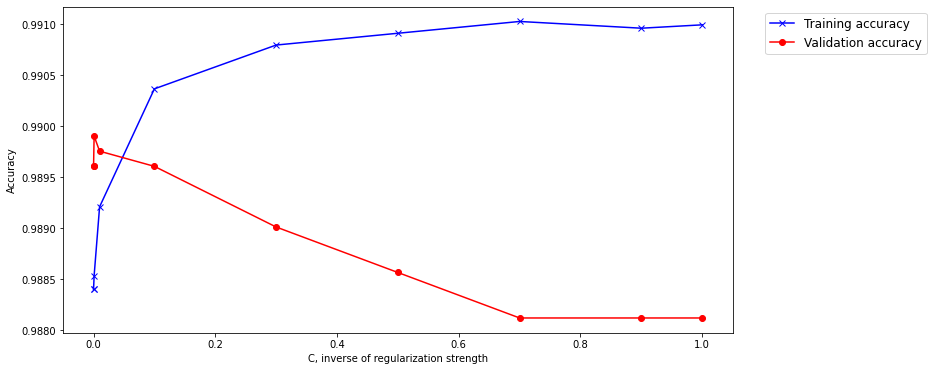

In [31]:
plt.figure(figsize=(12,6))

plt.plot(values_c, train_acc_c, 'bx-', label = "Training accuracy")
plt.plot(values_c, val_acc_c, 'ro-', label = "Validation accuracy")


#plt.title('Accuracy different setups')
plt.xlabel('C, inverse of regularization strength')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=12)
plt.show()

In [27]:
max_val_idx = np.where(val_acc_c == max(val_acc_c))[0][0]
c_chosen = values_c[max_val_idx]
print("C chosen :", c_chosen, "; Val acc", val_acc_c[max_val_idx])

C chosen : 0.001 ; Val acc 0.9899034892353378


We see that we obtained the highest validation accuracy of 98.99% when we set C = 0.001. Therefore, we will use this as our best model.

In [28]:
# Define Logistic Regression model
#lr_model = LogisticRegression(random_state=0, solver='liblinear')
lr_model = LogisticRegression(random_state=2, C = c_chosen, solver='lbfgs', max_iter = 4000)
# Fit the model to training data
lr_model.fit(train_embed, train_label)

# make prediction using the trained model
y_train_pred = lr_model.predict(train_embed)
y_val_pred = lr_model.predict(dev_embed)

In [29]:
train_accuracy = accuracy_score(train_label, y_train_pred)
val_accuracy = accuracy_score(dev_label, y_val_pred)

print("Training accuracy:", train_accuracy)
print("Validation accuracy:", val_accuracy) 

Training accuracy: 0.988534002045732
Validation accuracy: 0.9071100917431193
